In [1]:
!nvidia-smi

Sat Apr 13 18:12:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P8              N/A / ERR! |      6MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import torch

torch.cuda.get_device_name(0)

'NVIDIA GeForce MX150'

In [15]:
import matplotlib.pyplot as plt

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

color_map = plt.get_cmap("Set2")

2.2.2
11.8
True


## Karate

(undirected and unweighted)

In [2]:
def print_dataset_info(dataset):
    print(f"Dataset: {dataset}")
    print(f"Number of samples: {len(dataset)}")
    print(f"Number of features: {dataset.num_features}")
    print(f"Number of classes: {dataset.num_classes}")

In [5]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print_dataset_info(dataset)

Dataset: KarateClub()
Number of samples: 1
Number of features: 34
Number of classes: 4


In [6]:
G = dataset[0]
G

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [7]:
G.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [8]:
G.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [9]:
G.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

In [10]:
G.num_nodes

34

In [11]:
G.edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

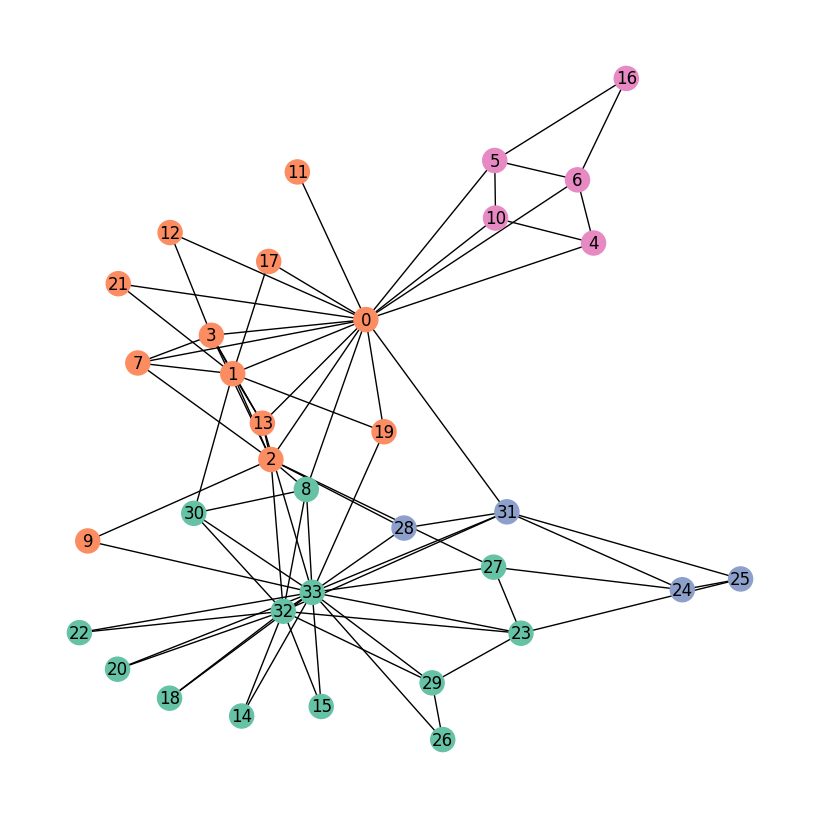

In [12]:
# Visualize the dataset

import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Create an adjacency matrix
adjacency_matrix = torch.zeros(G.num_nodes, G.num_nodes)
adjacency_matrix[G.edge_index[0], G.edge_index[1]] = 1

# Convert the adjacency matrix to numpy
adjacency_matrix_np = adjacency_matrix.numpy()

# Now create the graph
nx_G = nx.Graph(adjacency_matrix_np)
pos = nx.spring_layout(nx_G, seed=42)

colors = [color_map.colors[i] for i in G.y]

nx.draw(nx_G, pos, with_labels=True, node_color=colors, cmap="Set2")
plt.show()

In [41]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [14]:
from torch_geometric.transforms import RandomNodeSplit

data = RandomNodeSplit(num_val=0, num_test=0.2)(G)
data, data.train_mask, data.val_mask, data.test_mask

(Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34], val_mask=[34], test_mask=[34]),
 tensor([ True,  True,  True, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True, False,  True, False, False,  True,  True,  True,
          True,  True,  True, False,  True, False,  True,  True,  True,  True,
          True,  True, False,  True]),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False]),
 tensor([False, False, False,  True, False, False, False, False, False, False,
         False, False, False,  True, False,  True,  True, False, False, False,
         False, False, False,  True, False,  True, False, False, False, False,
         False, False,  True, False]))

In [19]:
def generate_adjacency_matrix(num_nodes, edge_index):
    adjacency_matrix = torch.zeros(num_nodes, num_nodes)
    adjacency_matrix[edge_index[0], edge_index[1]] = 1
    return adjacency_matrix.numpy()

/home/ignatella/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


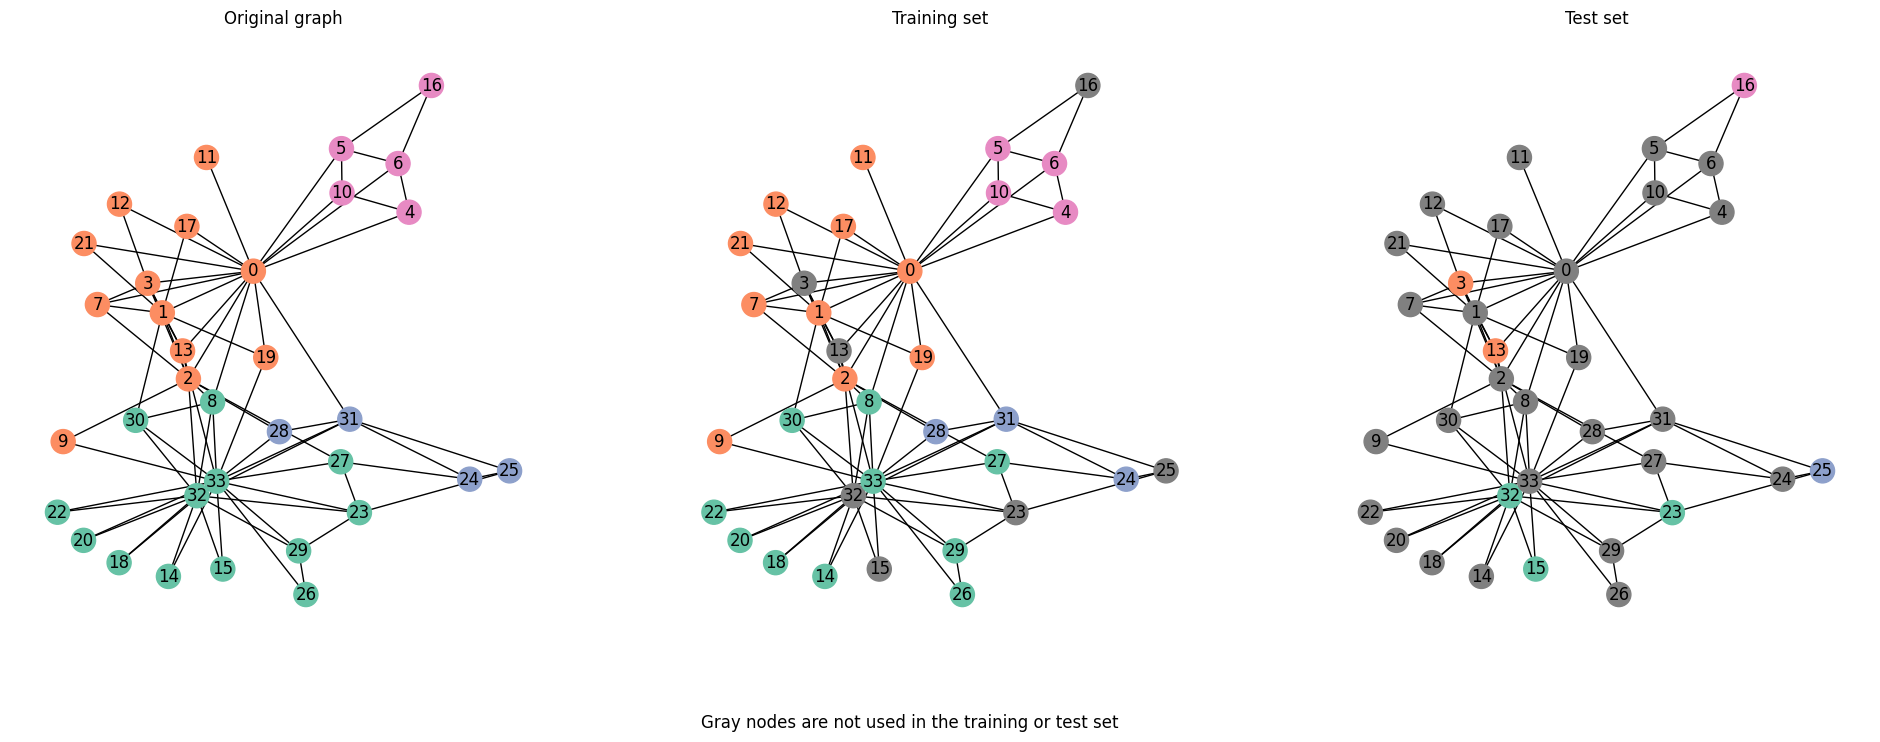

In [16]:
# plot nodes of the training set, unused nodes color is gray
plt.figure(figsize=(24, 8))

# Create an adjacency matrix
adjacency_matrix = generate_adjacency_matrix(data.num_nodes, data.edge_index)
# Now create the graph
nx_G = nx.Graph(adjacency_matrix)
# Create the layout
pos = nx.spring_layout(nx_G, seed=42)

original_colors = [color_map.colors[data.y[i].item()] for i in range(data.num_nodes)]
train_colors = [color_map.colors[data.y[i].item()] if use_node else "gray" for i, use_node in enumerate(data.train_mask)]
test_colors = [color_map.colors[data.y[i].item()] if use_node else "gray" for i, use_node in enumerate(data.test_mask)]

# Plot the original graph

plt.subplot(1, 3, 1)
nx.draw(nx_G, pos, with_labels=True, node_color=original_colors, cmap="Set2")
plt.title("Original graph")

# Plot the training set
plt.subplot(1, 3, 2)
nx.draw(nx_G, pos, with_labels=True, node_color=train_colors, cmap="Set2")
plt.title("Training set")

# Plot the test set
plt.subplot(1, 3, 3)
nx.draw(nx_G, pos, with_labels=True, node_color=test_colors, cmap="Set2")
plt.title("Test set")

# add additional text, that gray nodes are not used in the training or test set

plt.figtext(0.5, 0.01, "Gray nodes are not used in the training or test set", wrap=True, horizontalalignment='center', fontsize=12)

plt.show()

In [17]:
data.x[data.train_mask]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0

In [18]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels,)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=1)
        return x

In [19]:
# convert data.y to float
model = GCN(in_channels=-1, hidden_channels=64, out_channels=4)
model(data.x, data.edge_index)

tensor([[-1.4307, -1.3925, -1.4816, -1.2548],
        [-1.4118, -1.4034, -1.4641, -1.2756],
        [-1.4235, -1.3865, -1.4365, -1.3041],
        [-1.3923, -1.3954, -1.4330, -1.3274],
        [-1.3902, -1.3713, -1.4284, -1.3568],
        [-1.3743, -1.3609, -1.4535, -1.3594],
        [-1.3761, -1.3499, -1.4496, -1.3723],
        [-1.3920, -1.3896, -1.4325, -1.3336],
        [-1.4214, -1.3870, -1.4166, -1.3233],
        [-1.4219, -1.3887, -1.3862, -1.3496],
        [-1.3893, -1.3731, -1.4309, -1.3535],
        [-1.4440, -1.3835, -1.4225, -1.3013],
        [-1.3791, -1.4016, -1.4133, -1.3522],
        [-1.4066, -1.3847, -1.4274, -1.3292],
        [-1.4229, -1.3964, -1.4005, -1.3279],
        [-1.4300, -1.3957, -1.4063, -1.3168],
        [-1.3672, -1.3490, -1.4496, -1.3821],
        [-1.4064, -1.3988, -1.4289, -1.3148],
        [-1.4215, -1.3952, -1.3871, -1.3430],
        [-1.4095, -1.3969, -1.4267, -1.3157],
        [-1.4150, -1.4001, -1.3828, -1.3485],
        [-1.3873, -1.3977, -1.4402

In [20]:
# encode the class labels, so currently we have [1, 1, 1, 1, 2, 2, 4, 4, 3, 3, 3]
# it should become [[1., 0., 0., 0.], etc]

from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
data.y_encoded = onehot_encoder.fit_transform(data.y.view(-1, 1))
data.y_encoded = torch.tensor(data.y_encoded, dtype=torch.float32)

data.y_encoded

tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

In [21]:
model = GCN(in_channels=-1, hidden_channels=64, out_channels=dataset.num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(20):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    loss = criterion(out[data.train_mask], data.y_encoded[data.train_mask])
    loss.backward()
    optimizer.step()

    acc = (out[data.train_mask].argmax(dim=1) == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss {loss.item()} | Train Accuracy {acc}")

Epoch 0 | Loss 1.3869296312332153 | Train Accuracy 0.2222222222222222
Epoch 10 | Loss 0.904022753238678 | Train Accuracy 0.7037037037037037


In [22]:
# Test the model

model.eval()
out = model(data.x, data.edge_index)

acc = (out[data.test_mask].argmax(dim=1) == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print(f"Test Accuracy {acc}")

Test Accuracy 0.8571428571428571


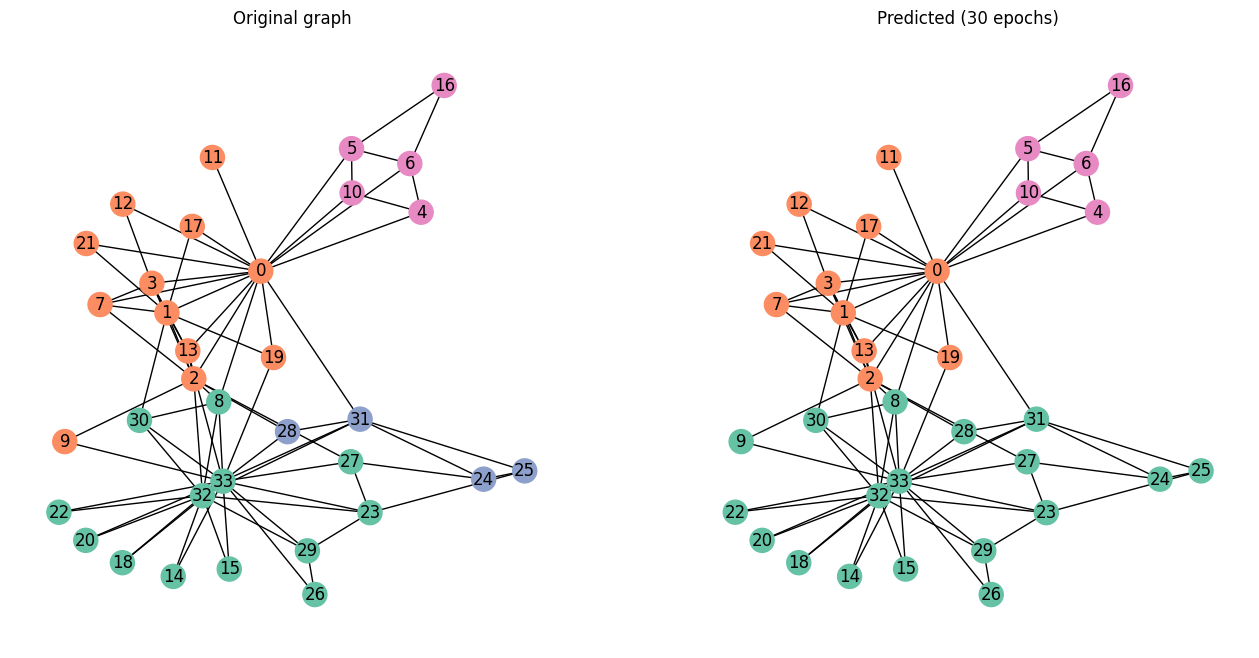

In [23]:
# plot nodes of the training set, unused nodes color is gray
plt.figure(figsize=(16, 8))

# Create an adjacency matrix
adjacency_matrix = generate_adjacency_matrix(data.num_nodes, data.edge_index)
# Now create the graph
nx_G = nx.Graph(adjacency_matrix)
# Create the layout
pos = nx.spring_layout(nx_G, seed=42)

out = model(data.x, data.edge_index)

original_colors = [color_map.colors[data.y[i].item()] for i in range(data.num_nodes)]
predicted_colors = [color_map.colors[i] for i in out.argmax(dim=1)]

# Plot the original graph

plt.subplot(1, 2, 1)
nx.draw(nx_G, pos, with_labels=True, node_color=original_colors, cmap="Set2")
plt.title("Original graph")

# Plot the training set
plt.subplot(1, 2, 2)
nx.draw(nx_G, pos, with_labels=True, node_color=predicted_colors, cmap="Set2")
plt.title("Predicted (30 epochs)")

plt.show()

In [24]:
model = GCN(in_channels=-1, hidden_channels=64, out_channels=dataset.num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    loss = criterion(out[data.train_mask], data.y_encoded[data.train_mask])
    loss.backward()
    optimizer.step()

    acc = (out[data.train_mask].argmax(dim=1) == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss {loss.item()} | Train Accuracy {acc}")

Epoch 0 | Loss 1.3851042985916138 | Train Accuracy 0.1111111111111111
Epoch 10 | Loss 0.8896350264549255 | Train Accuracy 0.7407407407407407
Epoch 20 | Loss 0.42304784059524536 | Train Accuracy 0.8888888888888888
Epoch 30 | Loss 0.18537789583206177 | Train Accuracy 1.0
Epoch 40 | Loss 0.09570396691560745 | Train Accuracy 1.0
Epoch 50 | Loss 0.05377676337957382 | Train Accuracy 1.0
Epoch 60 | Loss 0.03102184645831585 | Train Accuracy 1.0
Epoch 70 | Loss 0.019196920096874237 | Train Accuracy 1.0
Epoch 80 | Loss 0.012976914644241333 | Train Accuracy 1.0
Epoch 90 | Loss 0.00947399903088808 | Train Accuracy 1.0


In [25]:
# Test the model

model.eval()
out = model(data.x, data.edge_index)

acc = (out[data.test_mask].argmax(dim=1) == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print(f"Test Accuracy {acc}")

Test Accuracy 1.0


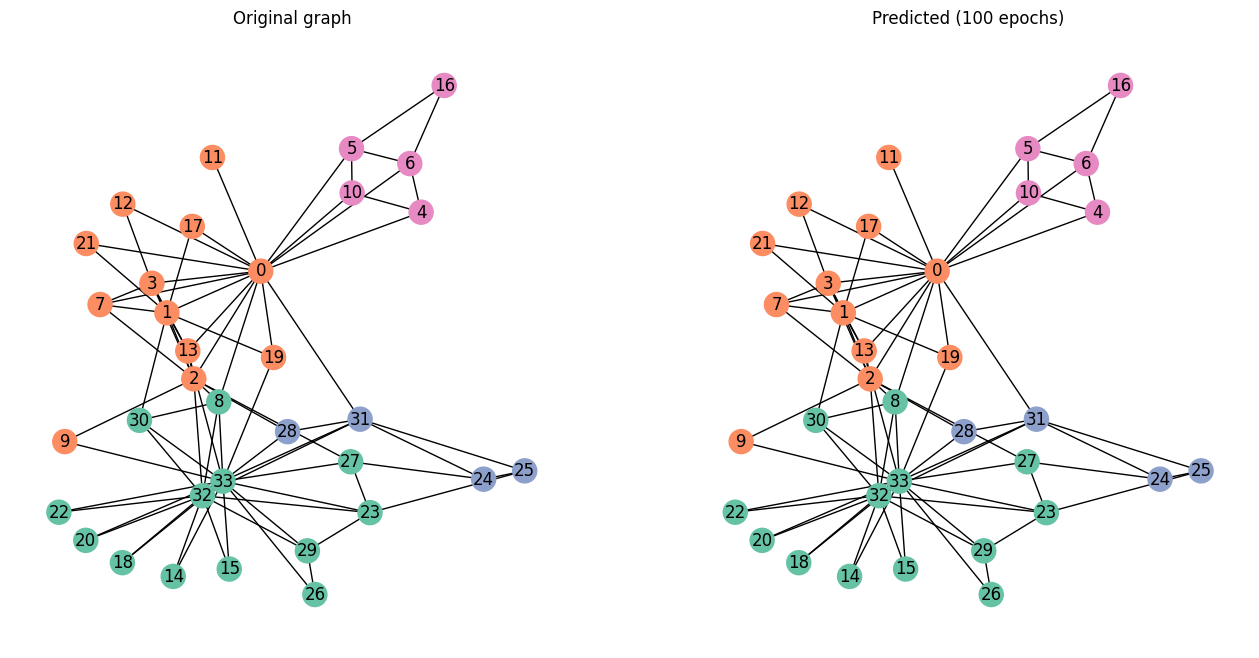

In [26]:
# plot nodes of the training set, unused nodes color is gray
plt.figure(figsize=(16, 8))

# Create an adjacency matrix
adjacency_matrix = generate_adjacency_matrix(data.num_nodes, data.edge_index)
# Now create the graph
nx_G = nx.Graph(adjacency_matrix)
# Create the layout
pos = nx.spring_layout(nx_G, seed=42)

out = model(data.x, data.edge_index)

original_colors = [color_map.colors[data.y[i].item()] for i in range(data.num_nodes)]
predicted_colors = [color_map.colors[i] for i in out.argmax(dim=1)]

# Plot the original graph

plt.subplot(1, 2, 1)
nx.draw(nx_G, pos, with_labels=True, node_color=original_colors, cmap="Set2")
plt.title("Original graph")

# Plot the training set
plt.subplot(1, 2, 2)
nx.draw(nx_G, pos, with_labels=True, node_color=predicted_colors, cmap="Set2")
plt.title("Predicted (100 epochs)")

plt.show()

In [27]:
# now let's try to add additional node connected to node 16

# zeros of size 34 x 1

new_node = torch.zeros((1, data.x.shape[1]))
edges = torch.tensor([[16, 34], [34, 16]], dtype=torch.long)

data.xx = torch.cat([data.x, new_node], dim=0)
data.edge_indexx = torch.cat([data.edge_index, edges], dim=1)
data.yy = torch.cat([data.y, torch.tensor([3])], dim=0)

In [28]:
data.yy

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 3])

In [29]:
data.num_nodes

34

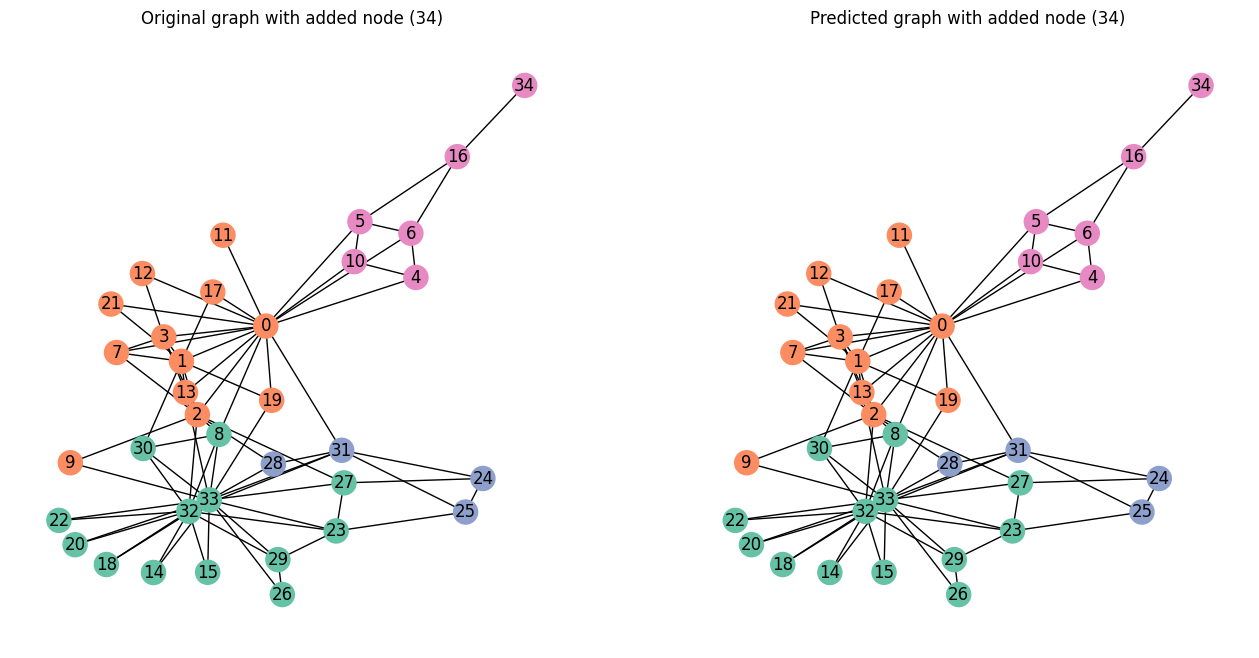

In [30]:
# plot nodes of the training set, unused nodes color is gray
plt.figure(figsize=(16, 8))

# Create an adjacency matrix
adjacency_matrix = generate_adjacency_matrix(data.num_nodes + 1, data.edge_indexx)
# Now create the graph
nx_G = nx.Graph(adjacency_matrix)
# Create the layout
pos = nx.spring_layout(nx_G, seed=42)

out = model(data.xx, data.edge_indexx)

original_colors = [color_map.colors[data.yy[i].item()] for i in range(data.num_nodes + 1)]
predicted_colors = [color_map.colors[i] for i in out.argmax(dim=1)]

# Plot the original graph
plt.subplot(1, 2, 1)
nx.draw(nx_G, pos, with_labels=True, node_color=original_colors, cmap="Set2")
plt.title("Original graph with added node (34)")

# Plot the training set
plt.subplot(1, 2, 2)
nx.draw(nx_G, pos, with_labels=True, node_color=predicted_colors, cmap="Set2")
plt.title("Predicted graph with added node (34)")

plt.show()

No i teraz sie zgadza !!!

### Texas

In [84]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [85]:
from torch_geometric.datasets import WebKB

dataset = WebKB(root='data', name='texas')
print_dataset_info(dataset)

Dataset: texas()
Number of samples: 1
Number of features: 1703
Number of classes: 5


In [86]:
G = dataset[0]
G

Data(x=[183, 1703], edge_index=[2, 325], y=[183], train_mask=[183, 10], val_mask=[183, 10], test_mask=[183, 10])

In [87]:
# show the first 10 nodes, without shortening the tensor
import torch

torch.set_printoptions(profile="full")
print(G.x[0]) # prints the whole tensor
torch.set_printoptions(profile="default")

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [88]:
G.y

tensor([3, 0, 2, 3, 4, 3, 0, 0, 3, 0, 3, 3, 3, 3, 3, 4, 3, 3, 0, 3, 0, 3, 3, 3,
        3, 1, 3, 3, 0, 2, 3, 3, 4, 3, 4, 4, 2, 3, 3, 3, 0, 4, 0, 3, 3, 3, 2, 2,
        0, 3, 0, 3, 3, 3, 3, 3, 0, 2, 2, 4, 4, 4, 3, 3, 3, 3, 0, 3, 3, 3, 4, 3,
        3, 4, 4, 3, 0, 3, 0, 3, 4, 3, 2, 4, 2, 4, 3, 3, 0, 3, 3, 3, 0, 3, 3, 4,
        3, 3, 3, 4, 0, 0, 4, 3, 3, 0, 4, 3, 2, 3, 3, 0, 3, 0, 0, 3, 3, 4, 3, 3,
        3, 0, 3, 0, 3, 2, 4, 2, 3, 3, 0, 4, 3, 4, 3, 4, 3, 3, 0, 3, 2, 3, 3, 3,
        3, 3, 3, 2, 3, 4, 3, 4, 3, 3, 3, 3, 0, 2, 0, 2, 3, 3, 4, 3, 0, 3, 3, 2,
        0, 3, 3, 4, 3, 2, 0, 3, 0, 4, 3, 3, 4, 3, 3])

In [89]:
G.num_nodes

183

In [90]:
# Visualize the dataset

import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(G, *args, main_title=''):
    plt.figure(figsize=(8 * len(args), 8))

    # Create an adjacency matrix
    adjacency_matrix = generate_adjacency_matrix(G.x.shape[0], G.edge_index)

    # Now create the graph
    nx_G = nx.Graph(adjacency_matrix)
    pos = nx.spring_layout(nx_G, seed=42)

    for i, arg in enumerate(args):
        colors = arg[0]
        title = arg[1]

        plt.subplot(1, len(args), i + 1)
        nx.draw(nx_G, pos, with_labels=True, node_color=colors, cmap="Set2")
        plt.title(title)

    if main_title:
        plt.figtext(0.5, 0.01, main_title, wrap=True, horizontalalignment='center', fontsize=12)

    plt.show()

In [92]:
from torch_geometric.transforms import RandomNodeSplit

data = RandomNodeSplit(num_val=0, num_test=0.2)(G)
data, data.train_mask, data.val_mask, data.test_mask

(Data(x=[183, 1703], edge_index=[2, 325], y=[183], train_mask=[183], val_mask=[183], test_mask=[183]),
 tensor([False,  True,  True, False,  True,  True,  True,  True,  True,  True,
          True,  True, False,  True,  True,  True,  True,  True,  True,  True,
          True, False,  True, False,  True,  True,  True, False, False,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False,  True,  True,  True,  True, False,  True,  True, False,  True,
          True, False,  True,  True,  True,  True,  True,  True, False,  True,
         False,  True,  True,  True, False,  True, False, False, False, False,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False,  True,  True,  True,  True,  True,  True,  True, False,  True,
         False,  True, False,  True, False, False,  True,  True,  True,  True,
         False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False,  True,  True

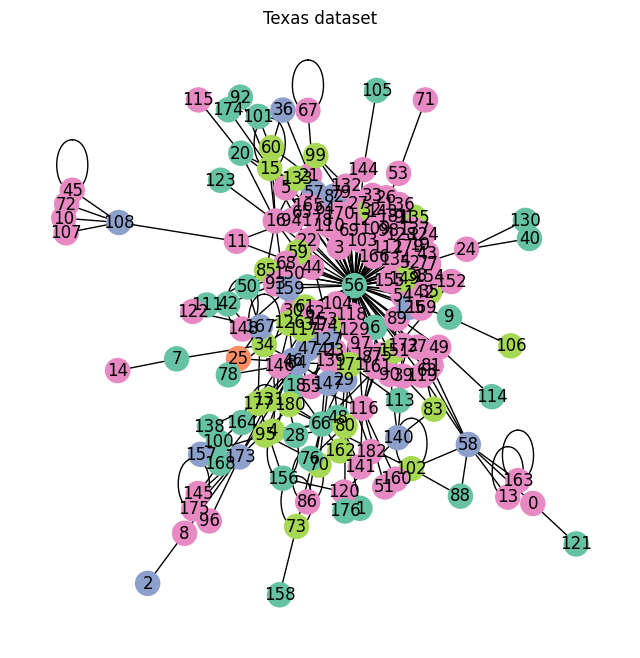

In [91]:
original_colors = [color_map.colors[data.y[i].item()] for i in range(data.num_nodes)]
draw_graph(data, (original_colors, "Texas dataset"))

In [93]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
data.y_encoded = onehot_encoder.fit_transform(data.y.view(-1, 1))
data.y_encoded = torch.tensor(data.y_encoded, dtype=torch.float32)

data.y_encoded

tensor([[0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0

In [17]:
import networkx as nx

def draw_graph(G, *args, main_title='', with_labels=True, font_size=12):
    plt.figure(figsize=(8 * len(args), 8))

    # Create an adjacency matrix
    adjacency_matrix = generate_adjacency_matrix(G.x.shape[0], G.edge_index)

    # Now create the graph
    nx_G = nx.Graph(adjacency_matrix)
    pos = nx.spring_layout(nx_G, seed=42)

    for i, arg in enumerate(args):
        colors = arg[0]
        title = arg[1]

        plt.subplot(1, len(args), i + 1)
        # control font size
        nx.draw(nx_G, pos, with_labels=with_labels, node_color=colors, cmap="Set2", font_size=font_size)
        plt.title(title)

    if main_title:
        plt.figtext(0.5, 0.01, main_title, wrap=True, horizontalalignment='center', fontsize=12)

    plt.show()

/home/ignatella/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


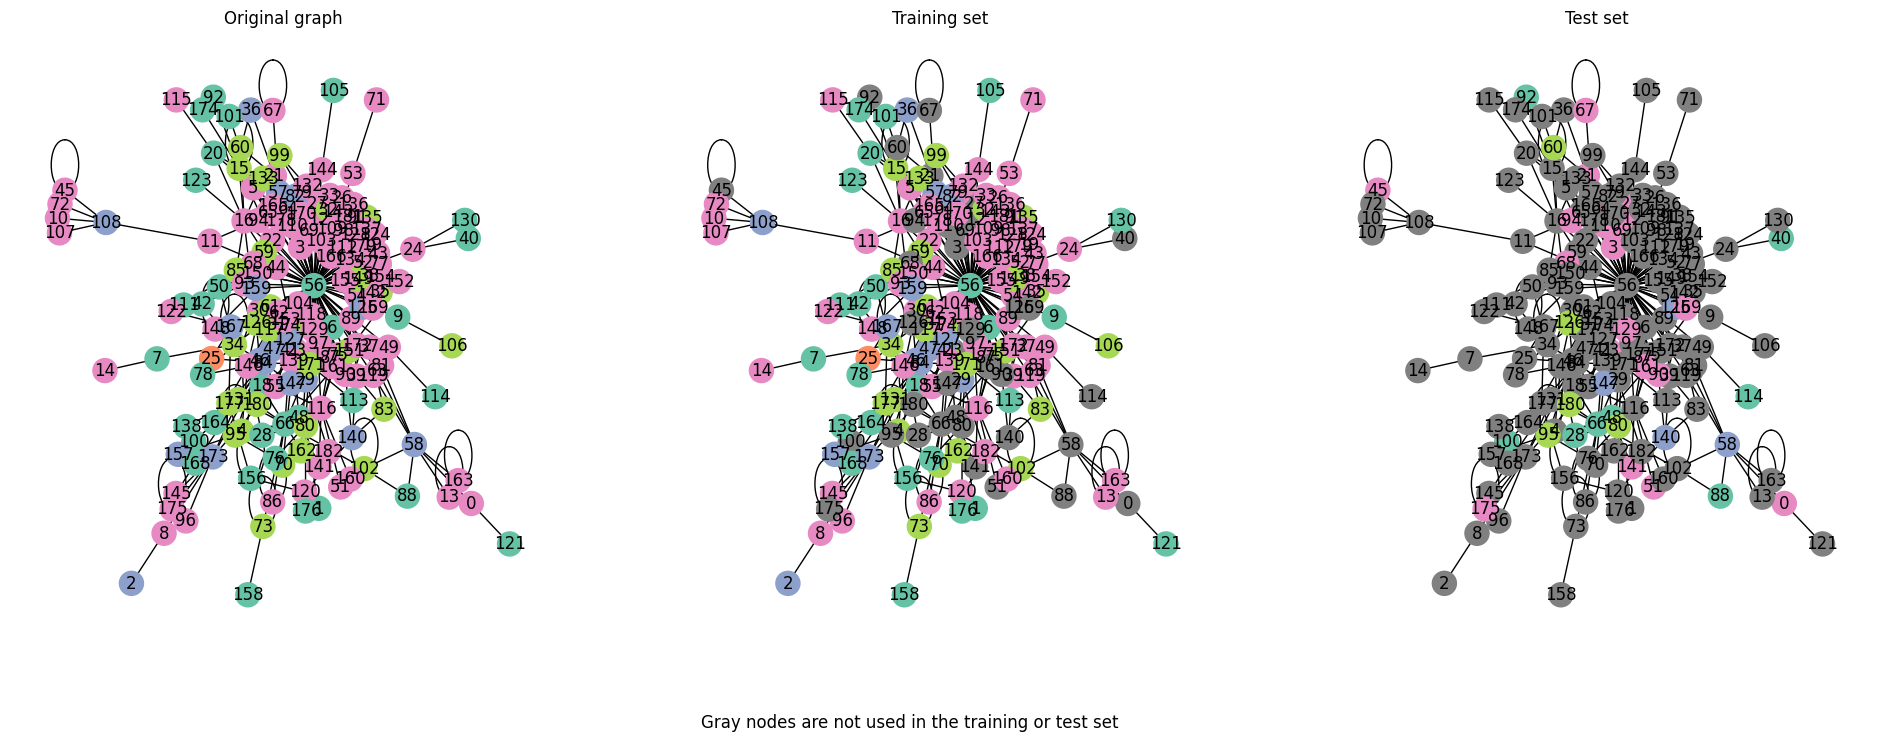

In [95]:
original_colors = [color_map.colors[data.y[i].item()] for i in range(data.num_nodes)]
train_colors = [color_map.colors[data.y[i].item()] if use_node else "gray" for i, use_node in enumerate(data.train_mask)]
test_colors = [color_map.colors[data.y[i].item()] if use_node else "gray" for i, use_node in enumerate(data.test_mask)]

draw_graph(data, (original_colors, "Original graph"), (train_colors, "Training set"), (test_colors, "Test set"), main_title="Gray nodes are not used in the training or test set")

In [96]:
import time

def train_model(model, data, epochs=100):
    model.train()

    start = time.time()

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)

        loss = criterion(out[data.train_mask], data.y_encoded[data.train_mask])
        loss.backward()
        optimizer.step()

        acc = (out[data.train_mask].argmax(dim=1) == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss {loss.item()} | Train Accuracy {acc}")
    
    end = time.time()

    print(f"Training took {end - start} seconds")

In [97]:
def test_model(model, data):
    model.eval()
    out = model(data.x, data.edge_index)

    acc = (out[data.test_mask].argmax(dim=1) == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    print(f"Test Accuracy {acc}")

In [104]:
model = GCN(in_channels=-1, hidden_channels=128, out_channels=dataset.num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_model(model, data, epochs=100)


Epoch 0 | Loss 1.7879126071929932 | Train Accuracy 0.1232876712328767
Epoch 10 | Loss 0.7899699807167053 | Train Accuracy 0.7123287671232876
Epoch 20 | Loss 0.5564056038856506 | Train Accuracy 0.7876712328767124
Epoch 30 | Loss 0.6456652879714966 | Train Accuracy 0.7397260273972602
Epoch 40 | Loss 0.4913993179798126 | Train Accuracy 0.8287671232876712
Epoch 50 | Loss 0.44091829657554626 | Train Accuracy 0.8356164383561644
Epoch 60 | Loss 0.4041454493999481 | Train Accuracy 0.8356164383561644
Epoch 70 | Loss 0.3352011442184448 | Train Accuracy 0.9041095890410958
Epoch 80 | Loss 0.3390568196773529 | Train Accuracy 0.8698630136986302
Epoch 90 | Loss 0.3927786946296692 | Train Accuracy 0.8767123287671232
Training took 0.5643997192382812 seconds


In [105]:
test_model(model, data)

Test Accuracy 0.35135135135135137


In [115]:
# test random classifier

import random

r = [random.randint(0, 4) for _ in range(data.test_mask.sum().item())]

acc = (torch.tensor(r) == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

print(f"Random classifier validation accuracy {acc}")


Random classifier validation accuracy 0.1891891891891892


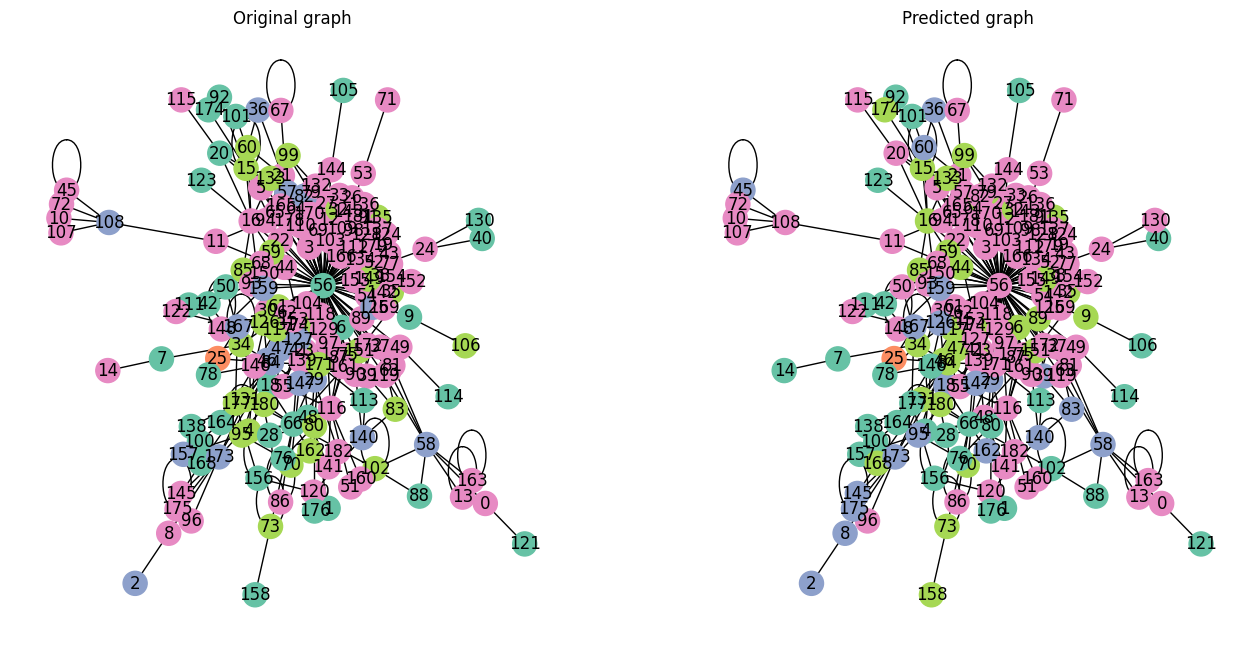

In [112]:
out = model(data.x, data.edge_index)

original_colors = [color_map.colors[data.y[i].item()] for i in range(data.num_nodes)]
predicted_colors = [color_map.colors[i] for i in out.argmax(dim=1)]

draw_graph(data, (original_colors, "Original graph"), (predicted_colors, "Predicted graph"))

### Cora

In [113]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='data', name='Cora')
print_dataset_info(dataset)

Dataset: Cora()
Number of samples: 1
Number of features: 1433
Number of classes: 7


Processing...
Done!


In [117]:
G = dataset[0]
G

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [118]:
# show the first 10 nodes, without shortening the tensor
import torch

torch.set_printoptions(profile="full")
print(G.x[0]) # prints the whole tensor
torch.set_printoptions(profile="default")

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [119]:
G.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [120]:
G.num_nodes

2708

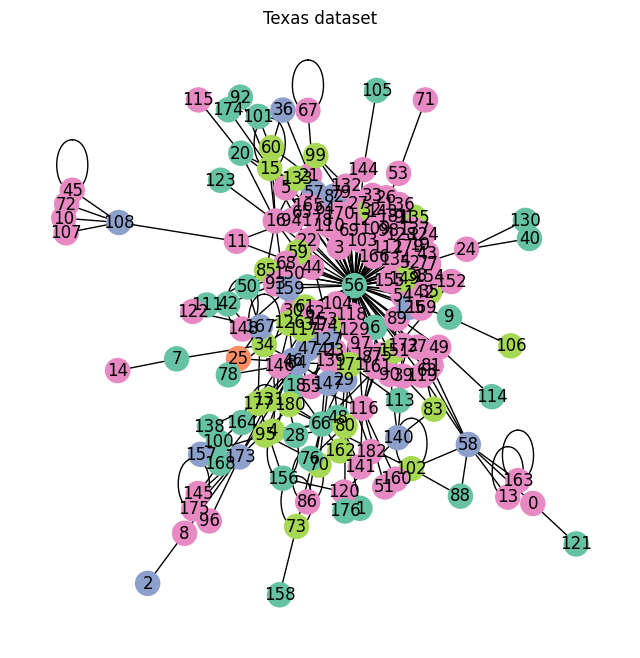

In [121]:
original_colors = [color_map.colors[data.y[i].item()] for i in range(data.num_nodes)]
draw_graph(data, (original_colors, "Texas dataset"))

In [122]:
from torch_geometric.transforms import RandomNodeSplit

data = RandomNodeSplit(num_val=0, num_test=0.2)(G)
data, data.train_mask, data.val_mask, data.test_mask

(Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708]),
 tensor([ True,  True,  True,  ..., False, False,  True]),
 tensor([False, False, False,  ..., False, False, False]),
 tensor([False, False, False,  ...,  True,  True, False]))

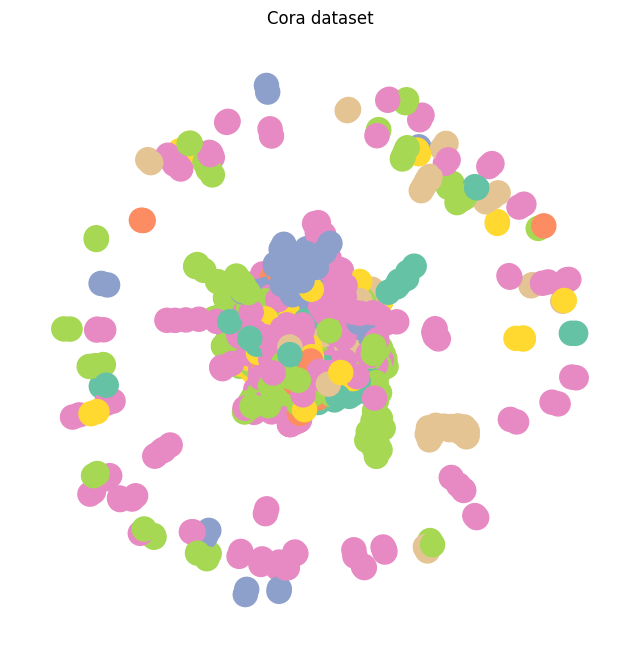

In [126]:
original_colors = [color_map.colors[data.y[i].item()] for i in range(data.num_nodes)]
draw_graph(data, (original_colors, "Cora dataset"), with_labels=False)

In [132]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
data.y_encoded = onehot_encoder.fit_transform(data.y.view(-1, 1))
data.y_encoded = torch.tensor(data.y_encoded, dtype=torch.float32)

data.y_encoded

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

/home/ignatella/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


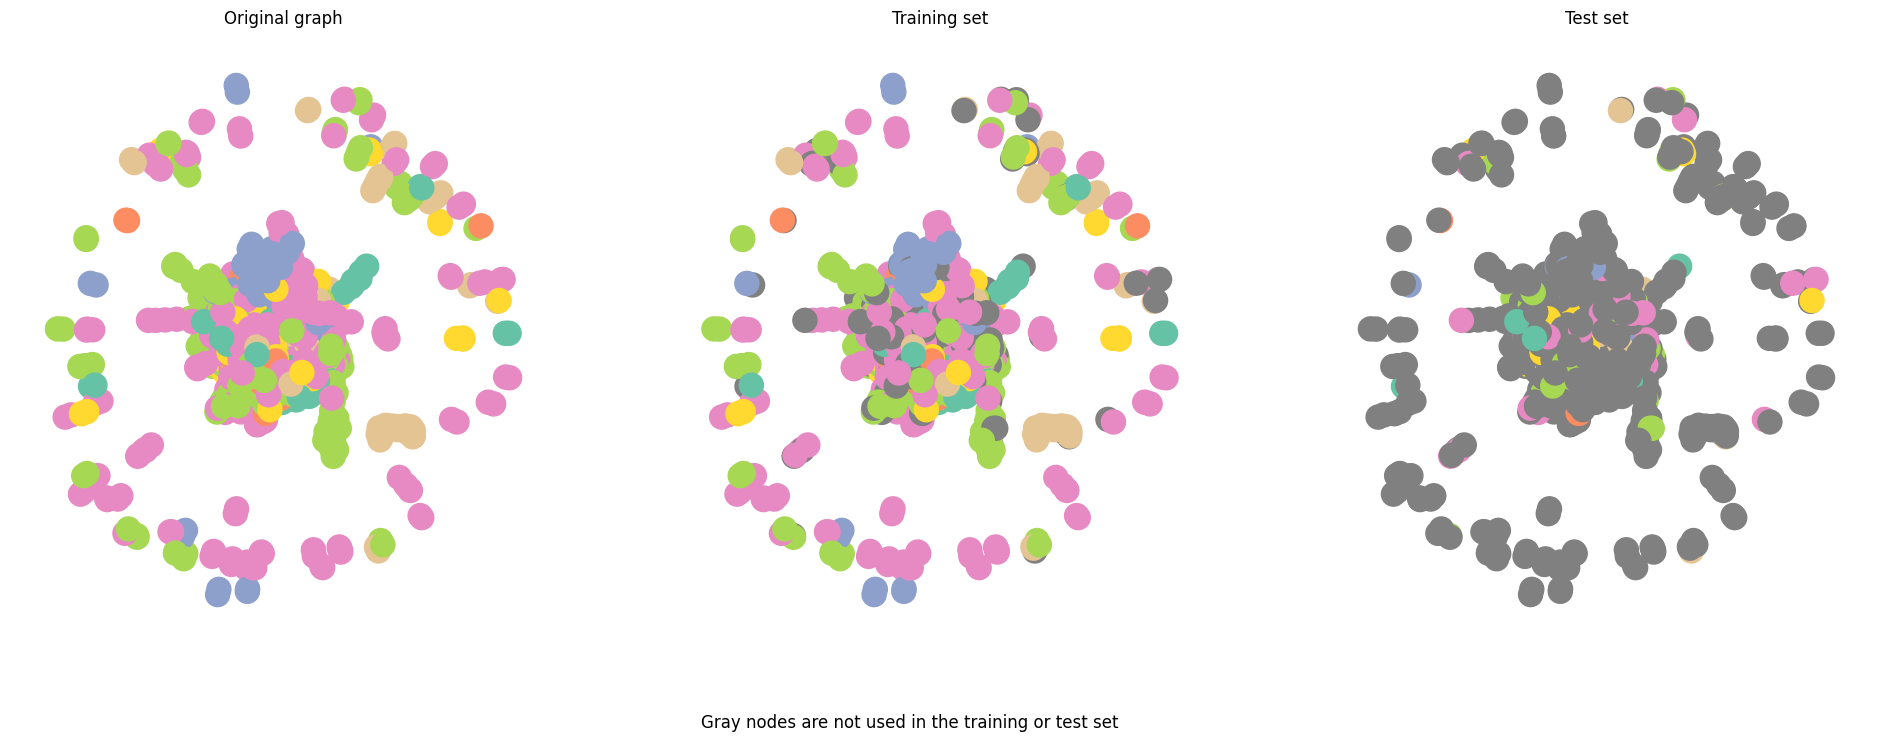

In [134]:
original_colors = [color_map.colors[data.y[i].item()] for i in range(data.num_nodes)]
train_colors = [color_map.colors[data.y[i].item()] if use_node else "gray" for i, use_node in enumerate(data.train_mask)]
test_colors = [color_map.colors[data.y[i].item()] if use_node else "gray" for i, use_node in enumerate(data.test_mask)]

draw_graph(data, (original_colors, "Original graph"), (train_colors, "Training set"), (test_colors, "Test set"), main_title="Gray nodes are not used in the training or test set", with_labels=False)


In [135]:
model = GCN(in_channels=-1, hidden_channels=128, out_channels=dataset.num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

train_model(model, data, epochs=100)

Epoch 0 | Loss 1.9580174684524536 | Train Accuracy 0.123730378578024
Epoch 10 | Loss 0.3628248870372772 | Train Accuracy 0.8998153277931671
Epoch 20 | Loss 0.2392701506614685 | Train Accuracy 0.9132040627885504
Epoch 30 | Loss 0.19341488182544708 | Train Accuracy 0.9265927977839336
Epoch 40 | Loss 0.1673257201910019 | Train Accuracy 0.9362880886426593
Epoch 50 | Loss 0.1564360409975052 | Train Accuracy 0.9473684210526315
Epoch 60 | Loss 0.14583563804626465 | Train Accuracy 0.9496768236380425
Epoch 70 | Loss 0.14132922887802124 | Train Accuracy 0.9469067405355494
Epoch 80 | Loss 0.12437385320663452 | Train Accuracy 0.9584487534626038
Epoch 90 | Loss 0.11841756105422974 | Train Accuracy 0.956140350877193
Training took 3.284252643585205 seconds


In [136]:
test_model(model, data)

Test Accuracy 0.8339483394833949


In [137]:
# test random classifier

import random

r = [random.randint(0, 4) for _ in range(data.test_mask.sum().item())]

acc = (torch.tensor(r) == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()

print(f"Random classifier validation accuracy {acc}")


Random classifier validation accuracy 0.14575645756457564


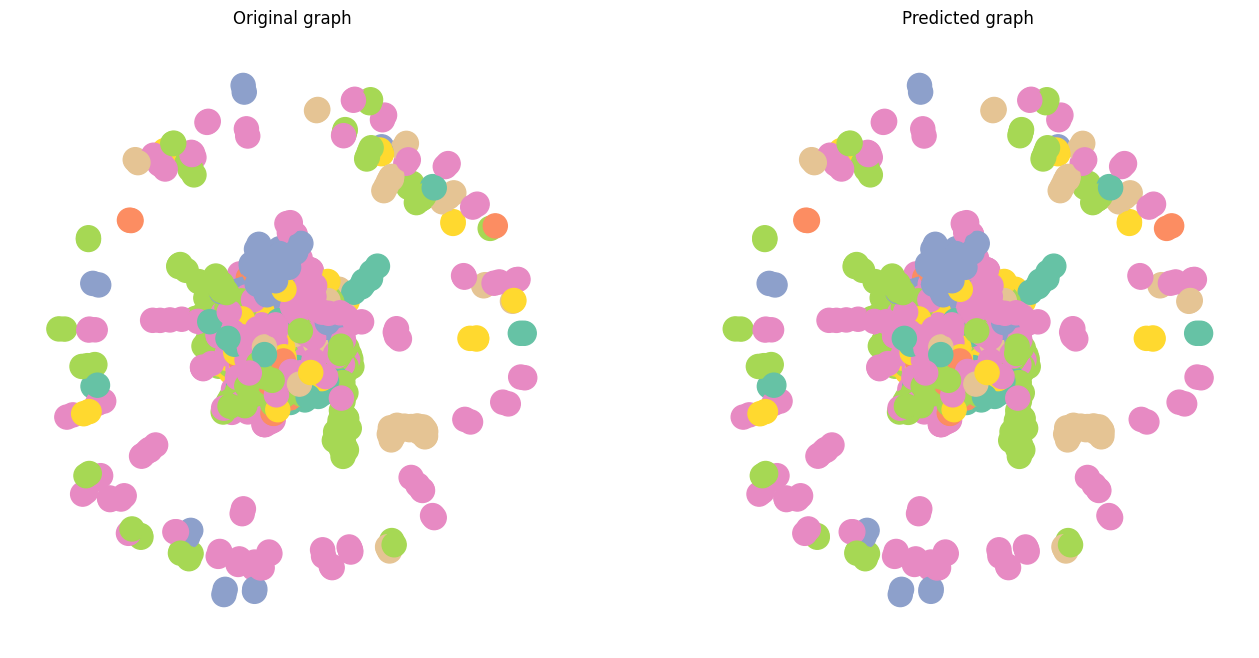

In [140]:
out = model(data.x, data.edge_index)

original_colors = [color_map.colors[data.y[i].item()] for i in range(data.num_nodes)]
predicted_colors = [color_map.colors[i] for i in out.argmax(dim=1)]

draw_graph(data, (original_colors, "Original graph"), (predicted_colors, "Predicted graph"), with_labels=False)

### Mutag

In [2]:
# import Mutag

from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data', name='MUTAG')

In [3]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]

print()
print(data)
print('=============================================================')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
train_dataset = dataset[:150]
test_dataset = dataset[150:]

In [5]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
def train_model(model, train_loader, test_loader, epochs=1_001):
    for epoch in range(0, epochs):

        for data in train_loader:
            model.train()

            y_encoded = onehot_encoder.fit_transform(data.y.view(-1, 1))
            y_encoded = torch.tensor(y_encoded, dtype=torch.float32)

            optimizer.zero_grad()

            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, y_encoded)
            loss.backward()
            optimizer.step()
        
        if epoch % 10 == 0:
            train_loss, train_acc = test_model(model, train_loader)
            test_loss, test_acc = test_model(model, test_loader)
            print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

In [7]:
@torch.no_grad()
def test_model(model, loader):
    model.eval()

    correct = 0
    test_loss = 0.0
    
    for data in loader:
        y_encoded = onehot_encoder.fit_transform(data.y.view(-1, 1))
        y_encoded = torch.tensor(y_encoded, dtype=torch.float32)

        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, y_encoded)
        test_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())

    return test_loss / len(loader.dataset), correct / len(loader.dataset)

##### GCN

In [8]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # dropout
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [9]:
from sklearn.preprocessing import OneHotEncoder

model = GCN(dataset.num_features, hidden_channels=64, out_channels=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
onehot_encoder = OneHotEncoder(sparse_output=False)

train_model(model, train_loader, test_loader, epochs=1_001)

Epoch: 000, Train Loss: 0.0213, Train Acc: 0.6600, Test Loss: 0.0355, Test Acc: 0.6842
Epoch: 010, Train Loss: 0.0182, Train Acc: 0.6800, Test Loss: 0.0303, Test Acc: 0.7105
Epoch: 020, Train Loss: 0.0181, Train Acc: 0.7200, Test Loss: 0.0299, Test Acc: 0.7105
Epoch: 030, Train Loss: 0.0180, Train Acc: 0.7133, Test Loss: 0.0303, Test Acc: 0.6842
Epoch: 040, Train Loss: 0.0176, Train Acc: 0.7733, Test Loss: 0.0286, Test Acc: 0.6579
Epoch: 050, Train Loss: 0.0182, Train Acc: 0.7133, Test Loss: 0.0300, Test Acc: 0.7105
Epoch: 060, Train Loss: 0.0190, Train Acc: 0.6933, Test Loss: 0.0323, Test Acc: 0.7105
Epoch: 070, Train Loss: 0.0177, Train Acc: 0.7067, Test Loss: 0.0304, Test Acc: 0.7105
Epoch: 080, Train Loss: 0.0200, Train Acc: 0.6933, Test Loss: 0.0332, Test Acc: 0.7105
Epoch: 090, Train Loss: 0.0183, Train Acc: 0.7133, Test Loss: 0.0315, Test Acc: 0.7368
Epoch: 100, Train Loss: 0.0177, Train Acc: 0.7267, Test Loss: 0.0319, Test Acc: 0.6842
Epoch: 110, Train Loss: 0.0182, Train Acc: 

In [10]:
test_model(model, train_loader), test_model(model, test_loader)

((0.019627614021301268, 0.68), (0.04378752959401984, 0.6842105263157895))

In [11]:
# test random classifier
import random

acc = 0

for data in test_loader:
    r = [random.randint(0,  dataset.num_classes + 1) for _ in range(data.y.shape[0])]

    acc += (torch.tensor(r) == data.y).sum().item() / data.y.shape[0]

print(f"Random classifier validation accuracy {acc / len(test_loader)}")

Random classifier validation accuracy 0.24479166666666666


In [12]:
# get first from the test_loader

batch = next(iter(test_loader))
batch, batch.num_nodes, batch.num_graphs

(DataBatch(edge_index=[2, 1276], x=[581, 7], edge_attr=[1276, 4], y=[32], batch=[581], ptr=[33]),
 581,
 32)

In [13]:
batch[0]

Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])

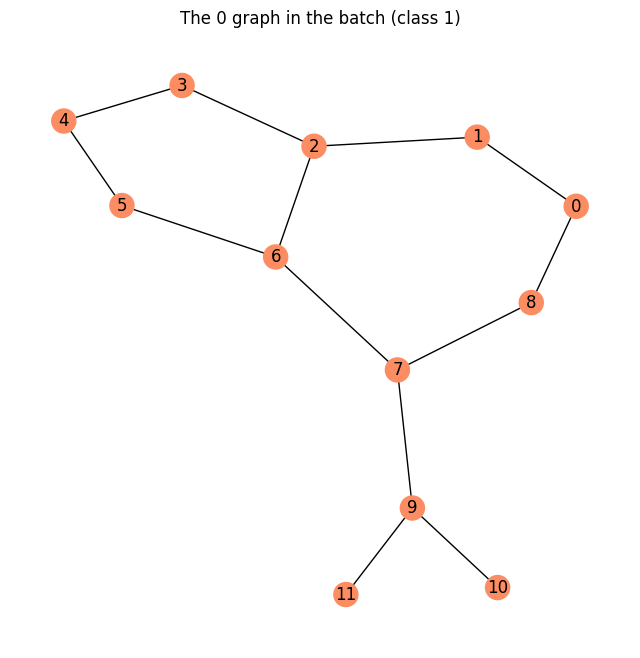

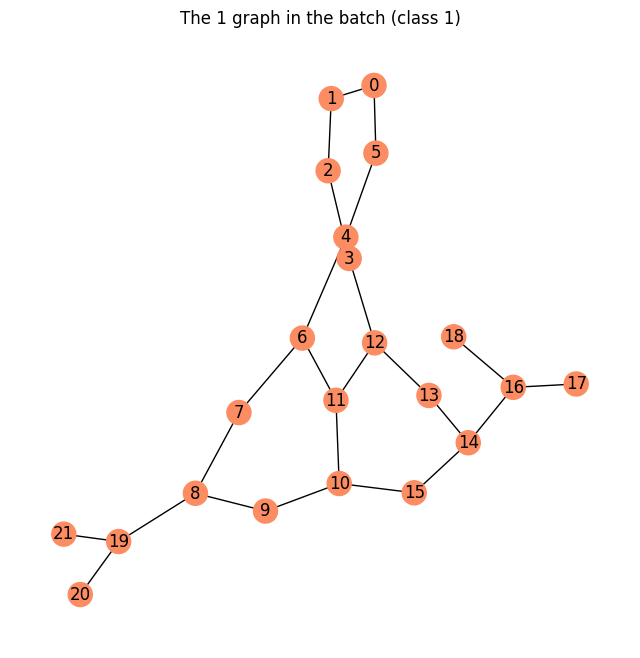

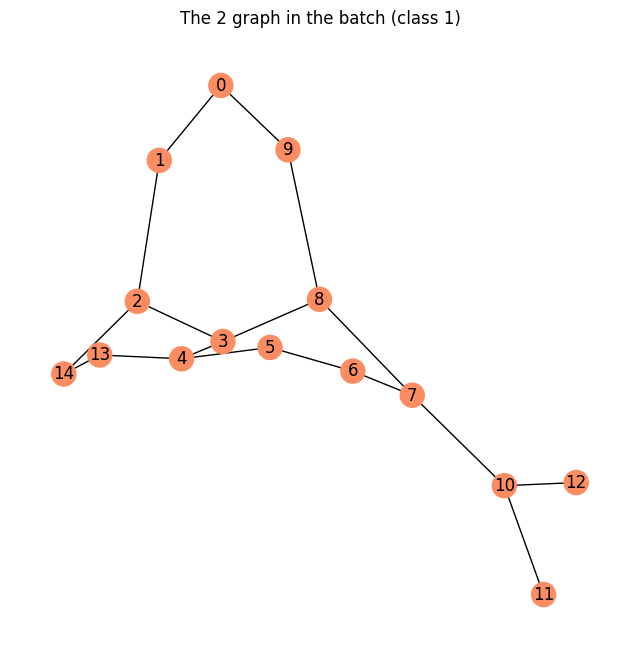

In [20]:
i = 0
colors = [color_map.colors[batch[i].y.item()] for _ in range(batch[i].x.shape[0])]
draw_graph(batch[i], (colors, f"The {i} graph in the batch (class {batch[i].y.item()})"), with_labels=True)
i = 1
colors = [color_map.colors[batch[i].y.item()] for _ in range(batch[i].x.shape[0])]
draw_graph(batch[i], (colors, f"The {i} graph in the batch (class {batch[i].y.item()})"), with_labels=True)
i = 2
colors = [color_map.colors[batch[i].y.item()] for _ in range(batch[i].x.shape[0])]
draw_graph(batch[i], (colors, f"The {i} graph in the batch (class {batch[i].y.item()})"), with_labels=True)


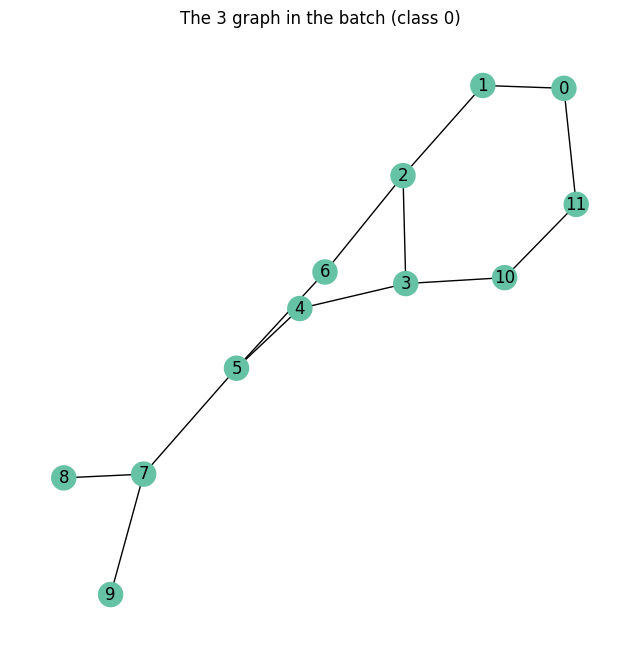

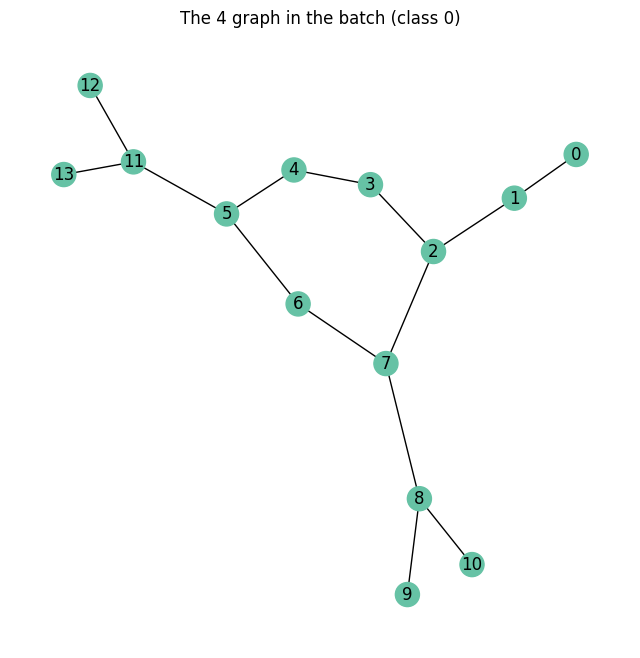

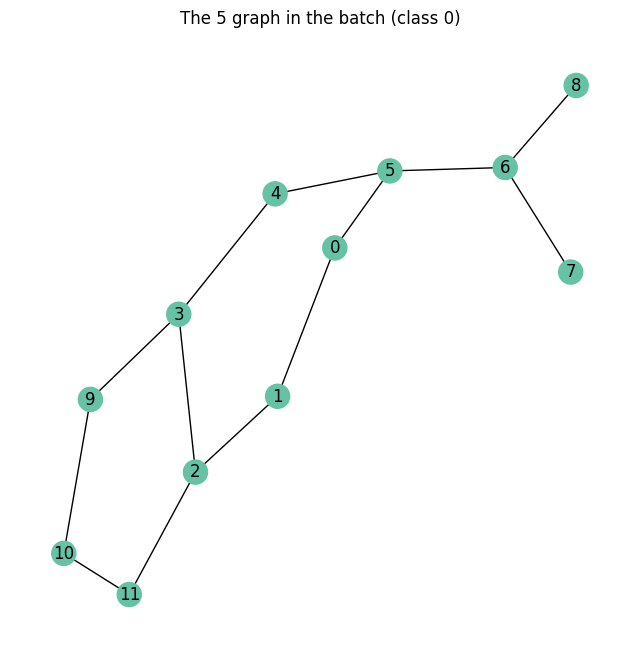

In [21]:
i = 3
colors = [color_map.colors[batch[i].y.item()] for _ in range(batch[i].x.shape[0])]
draw_graph(batch[i], (colors, f"The {i} graph in the batch (class {batch[i].y.item()})"), with_labels=True)
i = 4
colors = [color_map.colors[batch[i].y.item()] for _ in range(batch[i].x.shape[0])]
draw_graph(batch[i], (colors, f"The {i} graph in the batch (class {batch[i].y.item()})"), with_labels=True)
i = 5
colors = [color_map.colors[batch[i].y.item()] for _ in range(batch[i].x.shape[0])]
draw_graph(batch[i], (colors, f"The {i} graph in the batch (class {batch[i].y.item()})"), with_labels=True)

##### Gat

In [22]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # dropout
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [23]:
from sklearn.preprocessing import OneHotEncoder

model = GAT(dataset.num_features, hidden_channels=64, out_channels=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
onehot_encoder = OneHotEncoder(sparse_output=False)

train_model(model, train_loader, test_loader, epochs=1_001)

Epoch: 000, Train Loss: 0.0209, Train Acc: 0.6600, Test Loss: 0.0347, Test Acc: 0.6842
Epoch: 010, Train Loss: 0.0193, Train Acc: 0.6667, Test Loss: 0.0319, Test Acc: 0.6842
Epoch: 020, Train Loss: 0.0177, Train Acc: 0.7467, Test Loss: 0.0265, Test Acc: 0.7368
Epoch: 030, Train Loss: 0.0188, Train Acc: 0.7000, Test Loss: 0.0286, Test Acc: 0.7368
Epoch: 040, Train Loss: 0.0175, Train Acc: 0.7733, Test Loss: 0.0249, Test Acc: 0.7632
Epoch: 050, Train Loss: 0.0185, Train Acc: 0.7067, Test Loss: 0.0275, Test Acc: 0.7368
Epoch: 060, Train Loss: 0.0179, Train Acc: 0.7067, Test Loss: 0.0284, Test Acc: 0.7368
Epoch: 070, Train Loss: 0.0177, Train Acc: 0.6867, Test Loss: 0.0272, Test Acc: 0.7105
Epoch: 080, Train Loss: 0.0180, Train Acc: 0.7267, Test Loss: 0.0255, Test Acc: 0.7368
Epoch: 090, Train Loss: 0.0177, Train Acc: 0.7200, Test Loss: 0.0281, Test Acc: 0.7105
Epoch: 100, Train Loss: 0.0188, Train Acc: 0.7133, Test Loss: 0.0281, Test Acc: 0.7105
Epoch: 110, Train Loss: 0.0181, Train Acc: 

In [24]:
test_model(model, train_loader), test_model(model, test_loader)

((0.018075427611668905, 0.7133333333333334),
 (0.03415789259107489, 0.7105263157894737))

##### GIN

In [25]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import GINConv
from torch.nn import Sequential, ReLU

class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GIN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GINConv(Sequential(Linear(in_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels)))
        self.conv2 = GINConv(Sequential(Linear(hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels)))
        self.conv3 = GINConv(Sequential(Linear(hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels)))
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # dropout
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x
       

In [26]:
from sklearn.preprocessing import OneHotEncoder

model = GIN(dataset.num_features, hidden_channels=64, out_channels=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
onehot_encoder = OneHotEncoder(sparse_output=False)

train_model(model, train_loader, test_loader, epochs=1_001)

Epoch: 000, Train Loss: 0.0198, Train Acc: 0.6600, Test Loss: 0.0338, Test Acc: 0.6842
Epoch: 010, Train Loss: 0.0177, Train Acc: 0.7067, Test Loss: 0.0282, Test Acc: 0.6842
Epoch: 020, Train Loss: 0.0163, Train Acc: 0.7733, Test Loss: 0.0245, Test Acc: 0.7105
Epoch: 030, Train Loss: 0.0172, Train Acc: 0.7667, Test Loss: 0.0265, Test Acc: 0.7368
Epoch: 040, Train Loss: 0.0157, Train Acc: 0.7667, Test Loss: 0.0213, Test Acc: 0.7105
Epoch: 050, Train Loss: 0.0168, Train Acc: 0.7600, Test Loss: 0.0260, Test Acc: 0.7368
Epoch: 060, Train Loss: 0.0167, Train Acc: 0.7533, Test Loss: 0.0269, Test Acc: 0.7105
Epoch: 070, Train Loss: 0.0161, Train Acc: 0.7533, Test Loss: 0.0235, Test Acc: 0.7105
Epoch: 080, Train Loss: 0.0170, Train Acc: 0.7667, Test Loss: 0.0261, Test Acc: 0.7368
Epoch: 090, Train Loss: 0.0169, Train Acc: 0.7667, Test Loss: 0.0257, Test Acc: 0.7105
Epoch: 100, Train Loss: 0.0167, Train Acc: 0.7467, Test Loss: 0.0260, Test Acc: 0.7105
Epoch: 110, Train Loss: 0.0163, Train Acc: 

In [27]:
test_model(model, train_loader), test_model(model, test_loader)

((0.016245957215627035, 0.74), (0.03478271553390905, 0.7105263157894737))